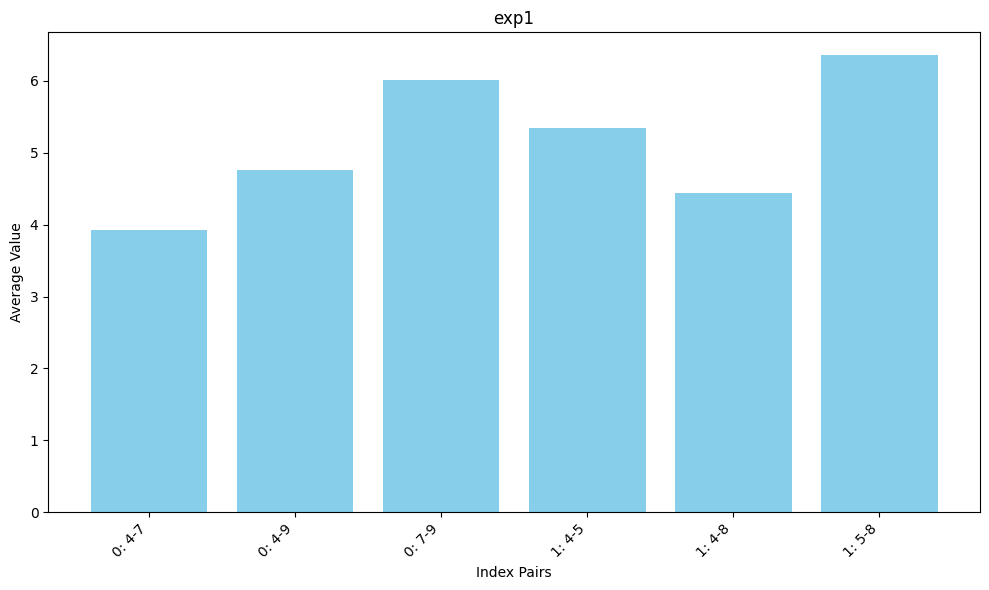

In [8]:
import json
import torch
import itertools
from pathlib import Path
import matplotlib.pyplot as plt
import os
import shutil

RESULTS_FOLDER = Path("results")

def setup_dummy_results():
    """Creates a dummy results directory with sample data."""
    if RESULTS_FOLDER.exists():
        shutil.rmtree(RESULTS_FOLDER)
    os.makedirs(RESULTS_FOLDER)

    # Experiment 1: type 'A'
    exp1_path = RESULTS_FOLDER / "exp1"
    os.makedirs(exp1_path)
    with open(exp1_path / "conditions.json", "w") as f:
        json.dump({"type": "A", "learning_rate": 0.01}, f)
    torch.save(torch.randn(10, 10) + 3, exp1_path / "matrix.pt")

    # Experiment 2: type 'B'
    exp2_path = RESULTS_FOLDER / "exp2"
    os.makedirs(exp2_path)
    with open(exp2_path / "conditions.json", "w") as f:
        json.dump({"type": "B", "learning_rate": 0.001}, f)
    torch.save(torch.randn(10, 10), exp2_path / "matrix.pt")

    # Experiment 3: type 'A'
    exp3_path = RESULTS_FOLDER / "exp3"
    os.makedirs(exp3_path)
    with open(exp3_path / "conditions.json", "w") as f:
        json.dump({"type": "A", "learning_rate": 0.005}, f)
    torch.save(torch.randn(10, 10), exp3_path / "matrix.pt")


def exp_to_hist(exp, groups=[(4, 7, 9), (4, 5, 8)]):
    m = torch.load(exp / "matrix.pt")
    hist = {}
    for group_ind, group in enumerate(groups):
        for i, j in itertools.combinations(group, 2):
            hist[f"{group_ind}: {i}-{j}"] = m[i][j] + m[j][i]
    return hist
    
def plot_confusion(hist, name):
    plt.figure(figsize=(10, 6))
    plt.bar(hist.keys(), hist.values())
    plt.xlabel("Index Pairs")
    plt.ylabel("Average Value")
    plt.title(name)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


def average_on(param: str, value):
    hist = {}
    amount = 0
    for exp_path in RESULTS_FOLDER.iterdir():
        conditions_path = exp_path / "conditions.json"
        if not conditions_path.exists():
            continue

        with open(conditions_path) as f:
            metadata = json.load(f)

        if metadata.get(param) == value:
            for key, val in exp_to_hist(exp_path).items():
                hist[key] = hist.get(key, 0) + val
            amount += 1

    for key in hist:
        hist[key] /= amount
    plot_confusion(hist, f"Average Histogram for '{param}' = '{value}' (averaged over {amount} experiments)")

setup_dummy_results()
plot_confusion(exp_to_hist(RESULTS_FOLDER / "exp1"), "exp1")